# Importing Libraries

In [29]:
import pandas as pd
import pmdarima as pm
from matplotlib import pyplot as plt
from utils.metrics import evaluate
from utils.plots import bar_metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

import warnings
warnings.filterwarnings('ignore')

# Reading Datasets

In [30]:
df=pd.read_csv("dataset/air_pollution.csv" ,parse_dates=['date'])
df.set_index('date', inplace=True)
df.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


# Dropping unused columns

In [31]:
df.drop(['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'pollution_yesterday'], axis=1, inplace=True)
df.head()

,pollution_today
date,
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333
2010-01-06,56.416667


In [32]:
#getting dataset insight
df.describe()

,pollution_today
count,1825.000000
mean,98.245080
std,76.807697
min,3.166667
25%,42.333333
50%,79.166667
75%,131.166667
max,541.895833


In [33]:
#checking for null values
df.isnull().any()

pollution_today    False
dtype: bool

# Plotting

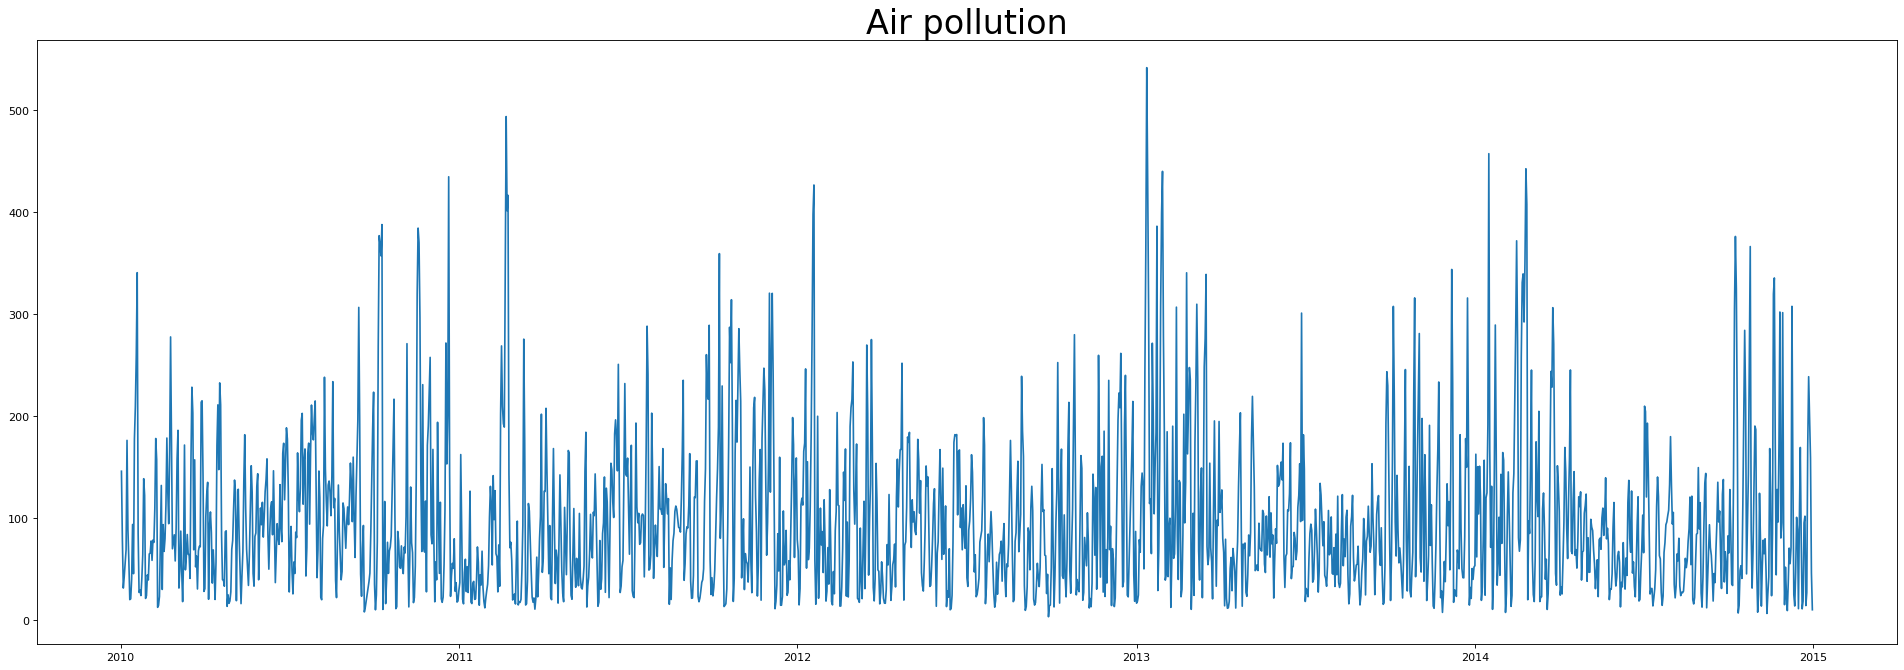

In [34]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(df["pollution_today"])

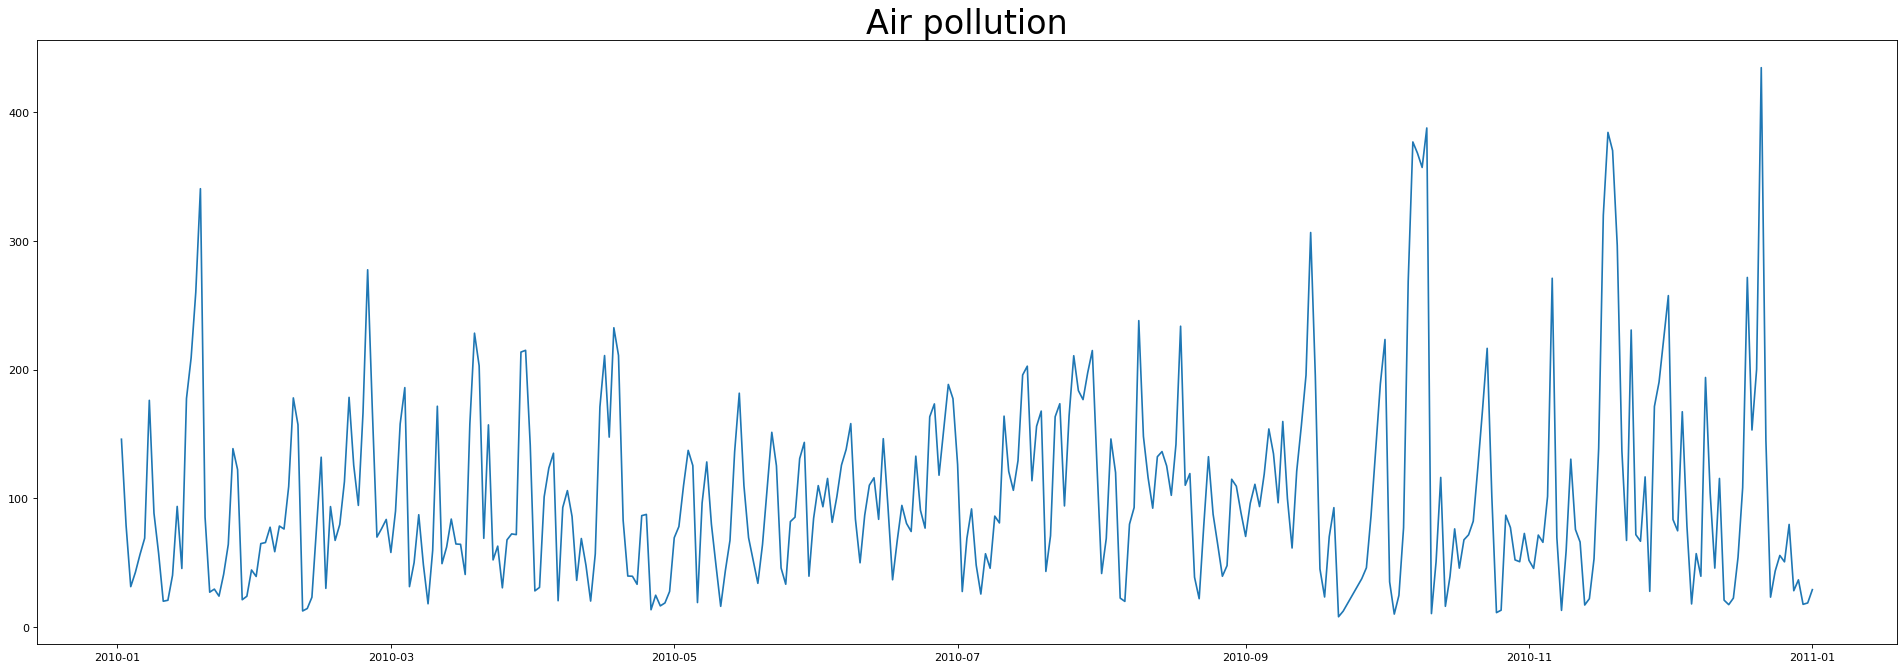

In [35]:
# plotting for a single year

plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(df["pollution_today"][:365])


# Time Resampling

<AxesSubplot:xlabel='date'>

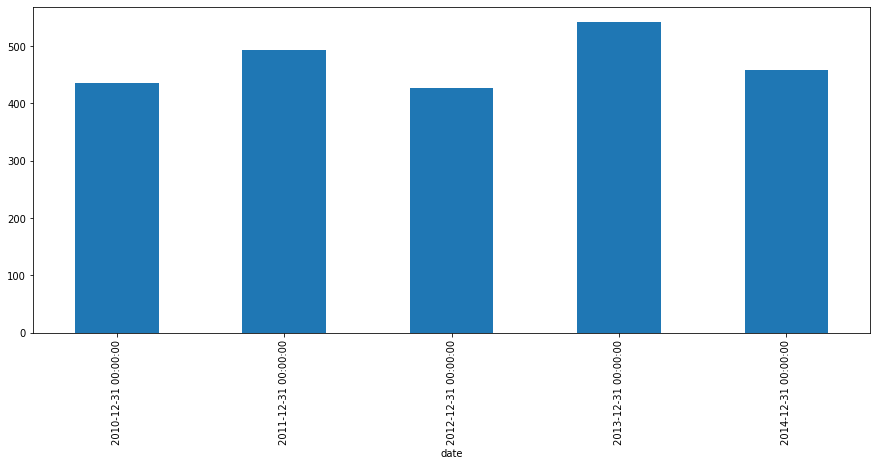

In [36]:
#Insight of pollution by Year
df['pollution_today'].resample(rule='A').max()
df['pollution_today'].resample(rule='A').max().plot(kind='bar',figsize=(15,6))


<AxesSubplot:xlabel='date'>

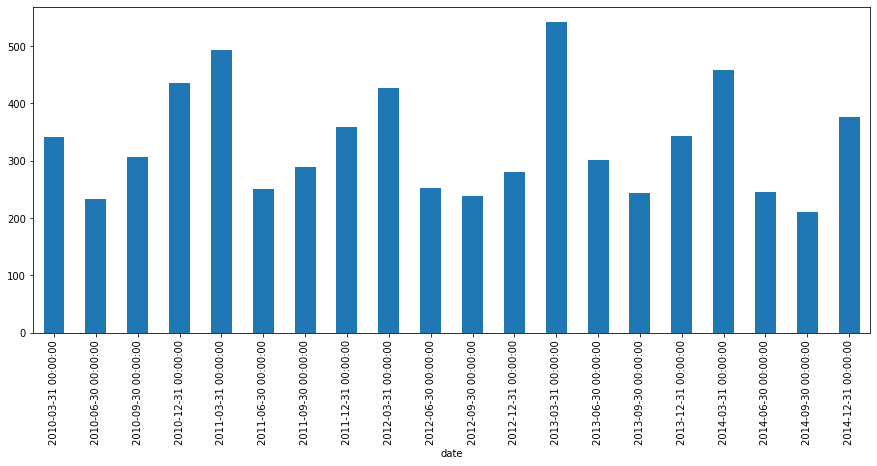

In [37]:
#Insight of pollution by Quartar
df['pollution_today'].resample(rule='Q').max()
df['pollution_today'].resample(rule='Q').max().plot(kind='bar',figsize=(15,6))



<AxesSubplot:xlabel='date'>

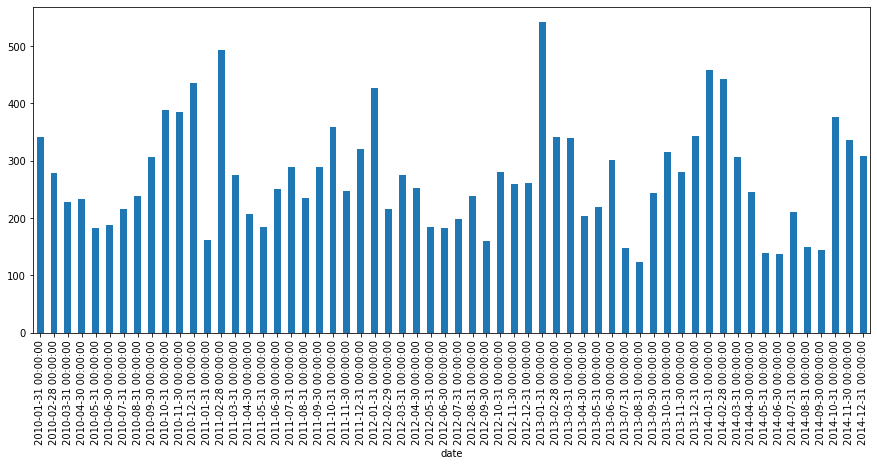

In [38]:

#Insight of pollution by Month
df['pollution_today'].resample(rule='M').max()
df['pollution_today'].resample(rule='M').max().plot(kind='bar',figsize=(15,6))



<AxesSubplot:xlabel='date'>

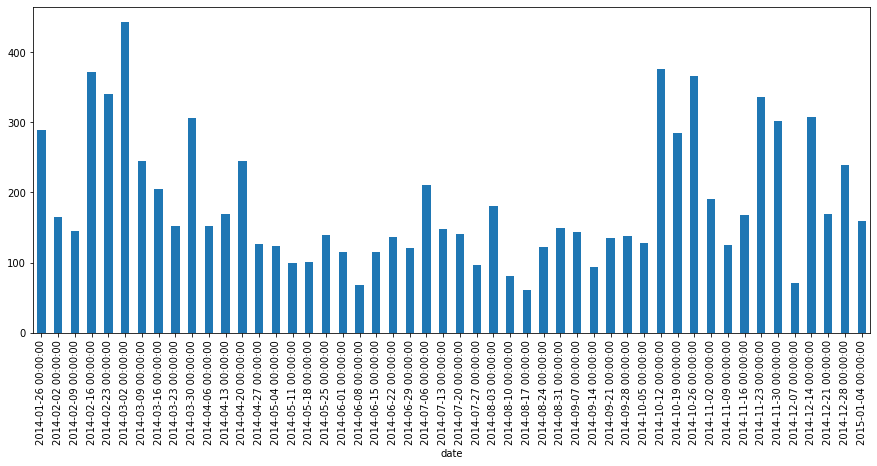

In [39]:

#Insight of pollution by Week
df['pollution_today'].resample(rule='W').max()
df['pollution_today'].resample(rule='W').max()[-50:].plot(kind='bar',figsize=(15,6))


<AxesSubplot:xlabel='date'>

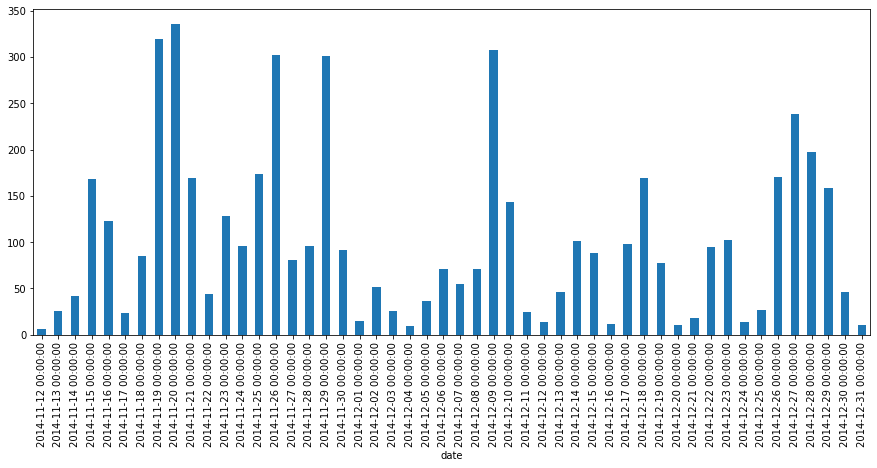

In [40]:


#Insight of pollution by Day
df['pollution_today'].resample(rule='D').max()
df['pollution_today'].resample(rule='D').max()[-50:].plot(kind='bar',figsize=(15,6))

# Decomposition of ZTime Series Dataset

In [41]:
decomposed=seasonal_decompose(df["pollution_today"][:365], model='multiplicative')


<AxesSubplot:xlabel='date'>

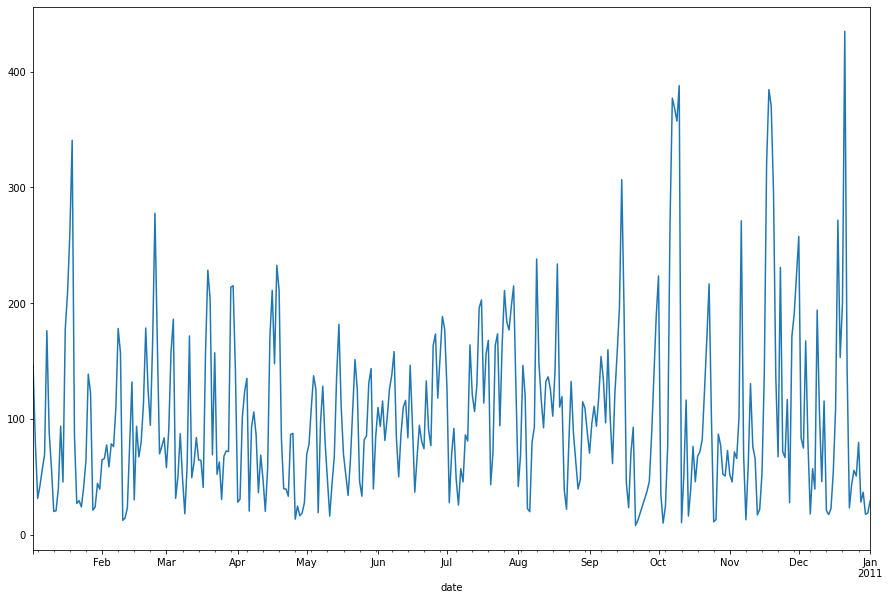

In [42]:
# original
df["pollution_today"][:365].plot(figsize=(15,10))

<AxesSubplot:xlabel='date'>

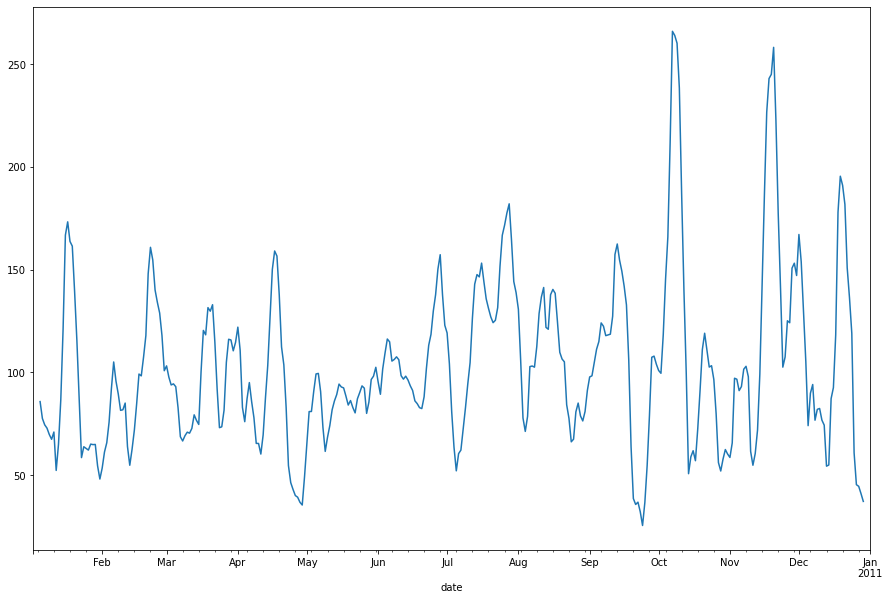

In [43]:
#Trending
decomposed.trend.plot(figsize=(15,10))

<AxesSubplot:xlabel='date'>

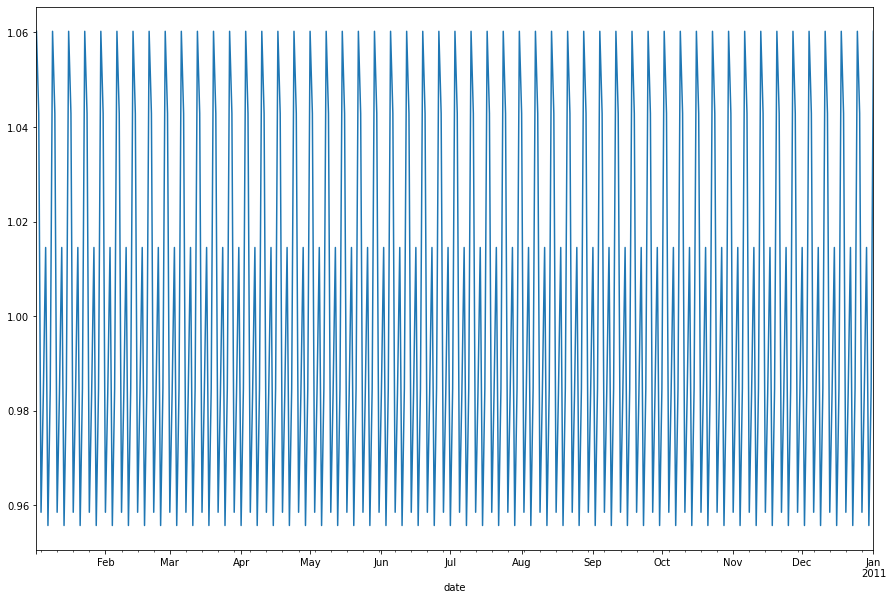

In [44]:
#Seasonality
decomposed.seasonal.plot(figsize=(15,10))

<AxesSubplot:xlabel='date'>

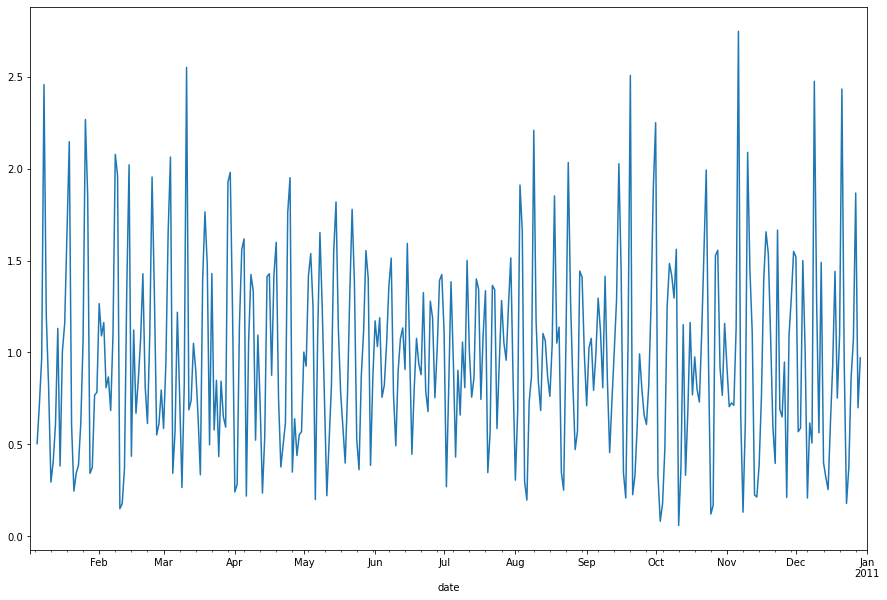

In [45]:
#Noise
decomposed.resid.plot(figsize=(15,10))

# Checking for Stationary

In [46]:
# By Dickey Fuller test

def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [47]:
adf_test(df['pollution_today'])

ADF Statistics: -10.116719049378307
p- value: 9.680895053878909e-18
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

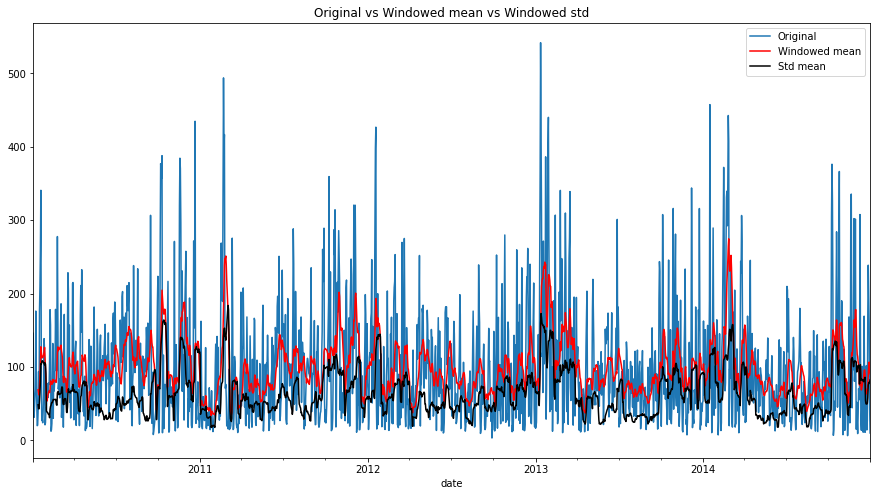

In [48]:
df['pollution_today'].plot(label='Original',figsize=(15,8))
df['pollution_today'].rolling(window=12).mean().plot(color='red', label='Windowed mean',figsize=(15,8))
df['pollution_today'].rolling(window=12).std().plot(color='black', label='Std mean',figsize=(15,8))
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

# Spliting the dataset into test and train set

In [49]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2014-01-01'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1461 days of training data 
 364 days of testing data 


# Simple Exponential Smoothing (SES)

In [50]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train["pollution_today"])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['SES'] = yhat.values

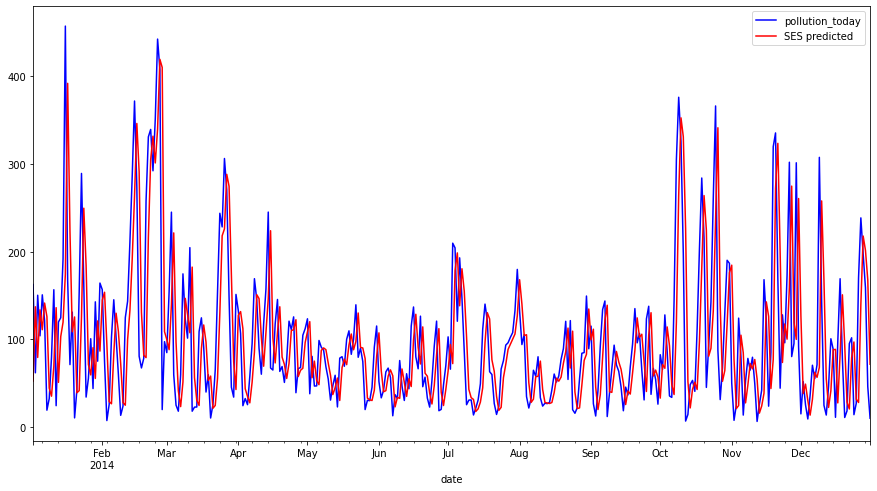

In [51]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='SES predicted',figsize=(15,8))
plt.legend()

# Holt Winter’s Exponential Smoothing (HWES)

In [52]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train["pollution_today"])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['HWES'] = yhat.values

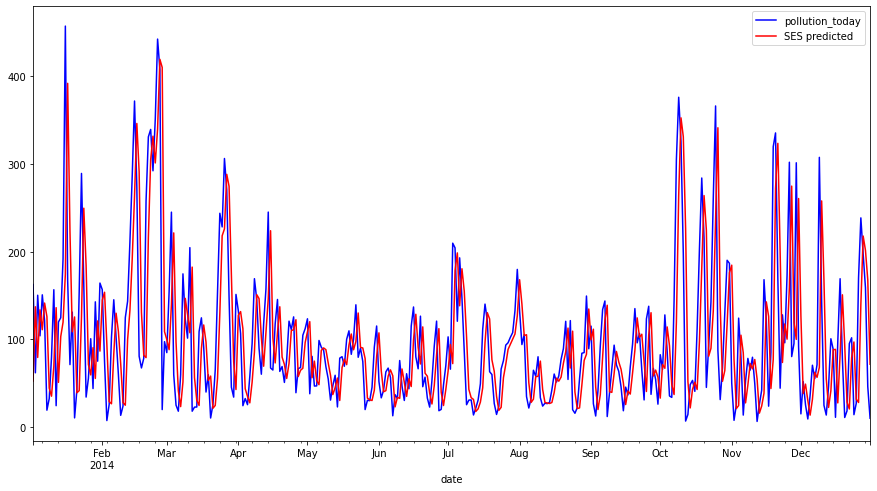

In [53]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='SES predicted',figsize=(15,8))
plt.legend()

# Autoregression (AR)


In [54]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = AR(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['AR'] = yhat.values

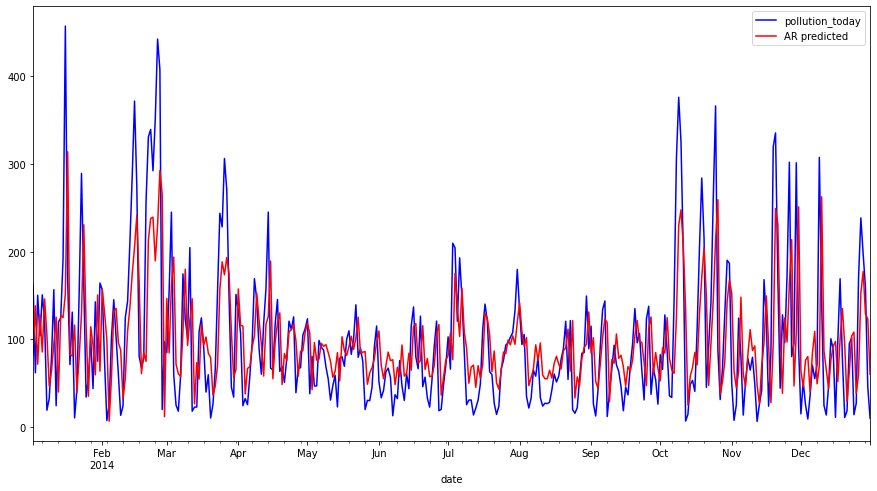

In [55]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='AR predicted',figsize=(15,8))
plt.legend()

# Moving Average (MA)

In [56]:
# MA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test.pollution_today)):
    temp_train = df[:len(df_training)+t]
    model = ARMA(temp_train["pollution_today"], order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['MA'] = yhat.values

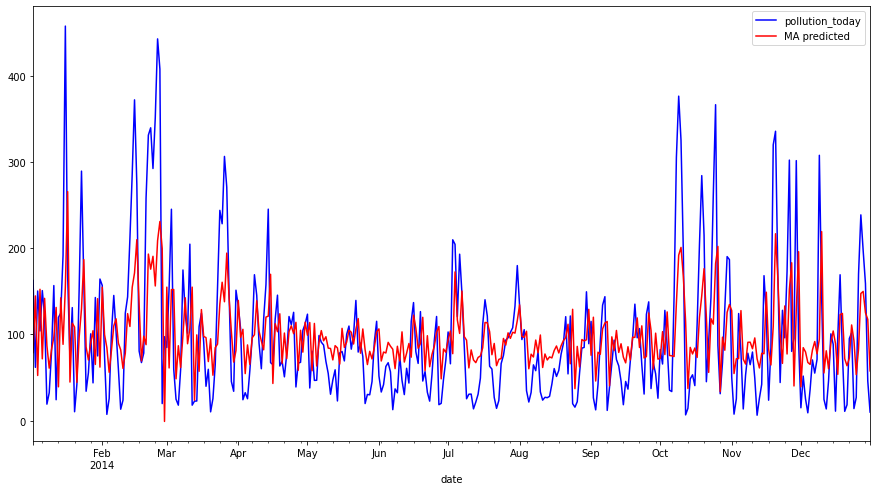

In [57]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='MA predicted',figsize=(15,8))
plt.legend()

# ACF and PACF

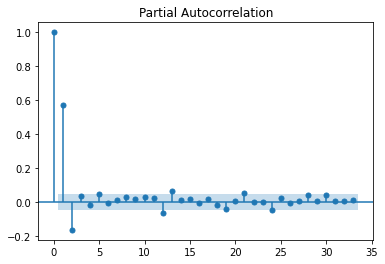

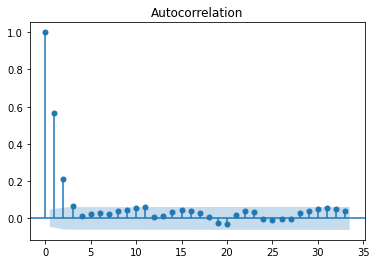

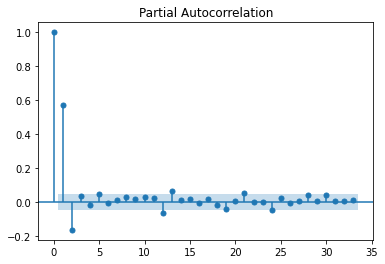

In [58]:
plot_acf(df["pollution_today"])
plot_pacf(df["pollution_today"])

# Auto Autoregressive integrated moving average (ARIMA)

In [59]:
# building the model

autoModel = pm.auto_arima(df_training["pollution_today"], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training["pollution_today"])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18232.724, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16461.265, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17191.945, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16462.630, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16462.086, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16455.385, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16266.588, Time=0.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16869.411, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16217.321, Time=0.87 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16711.266, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=2.11 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=1.72 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [61]:
order = autoModel.order
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train["pollution_today"], order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.pollution_today, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

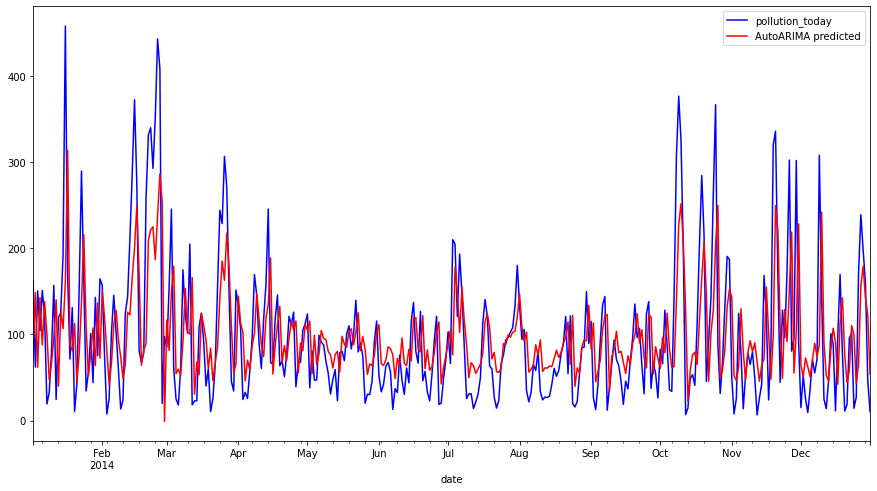

In [62]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='AutoARIMA predicted',figsize=(15,8))
plt.legend()

# Auto Seasonal Auto Regressive Integerated Moving Average (SARIMA)

In [63]:
# building the model
autoModel = pm.auto_arima(df_training["pollution_today"], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training["pollution_today"])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=16199.933, Time=3.53 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=16788.406, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=16229.161, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=16265.917, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=18232.724, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=16200.349, Time=0.70 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=16200.355, Time=0.68 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=16203.879, Time=2.05 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=16203.861, Time=2.38 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=16198.453, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=16196.487, Time=0.84 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=16198.378, Time=1.55 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=16198.371, Time=1.77 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=16200.253, Time=1.08 sec
 ARIMA(0,0,2)(0,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [64]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train["pollution_today"], order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test.pollution_today, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

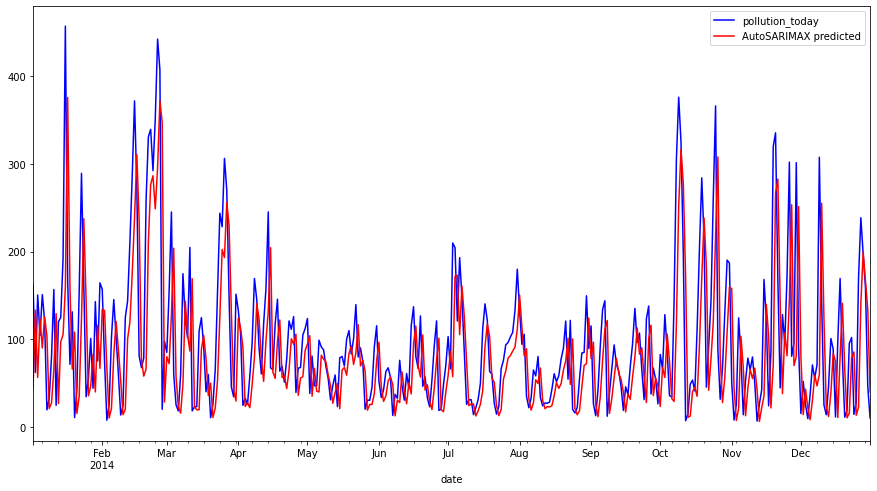

In [65]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='AutoSARIMAX predicted',figsize=(15,8))
plt.legend()
